In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
import seaborn as sns
from google.colab import drive
from shapely.geometry import Point, Polygon
import geopandas as gpd

# 数据加载与预处理

from google.colab import drive
drive.mount('/content/drive')

# 加载数据
light_data = pd.read_csv("/content/drive/MyDrive/monthly_avg_nsb_location.csv")
species_data = pd.read_csv("/content/drive/MyDrive/2022_with_lat_lon.csv")

light_data['latitude'] = light_data['latitude'].round(1)
light_data['longitude'] = light_data['longitude'].round(1)
species_data['latitude'] = species_data['latitude'].round(1)
species_data['longitude'] = species_data['longitude'].round(1)


# 合并光强数据和物种分布数据
merged_data = pd.merge(
    light_data,
    species_data,
    left_on=['latitude', 'longitude', 'month'],
    right_on=['latitude', 'longitude', 'month'],
    how='inner'
)

# 检查合并后的数据是否为空
if merged_data.empty:
    print("合并后的数据为空！以下是调试信息：")
    print("光强数据的经纬度范围：")
    print(light_data[['latitude', 'longitude']].agg(['min', 'max']))
    print("\n物种分布数据的经纬度范围：")
    print(species_data[['latitude', 'longitude']].agg(['min', 'max']))
    print("\n光强数据的时间范围：")
    print(light_data['month'].unique())
    print("\n物种分布数据的时间范围：")
    print(species_data['month'].unique())
    raise ValueError("合并失败，请检查数据匹配逻辑！")



Mounted at /content/drive


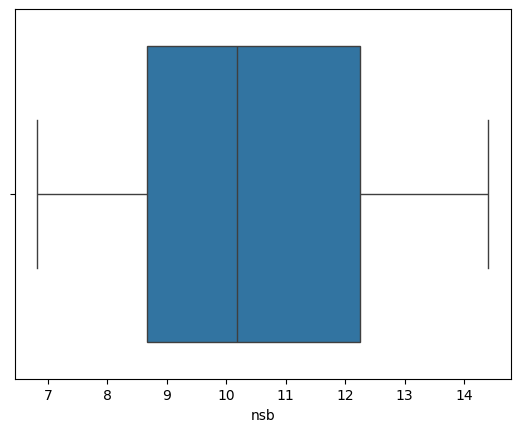

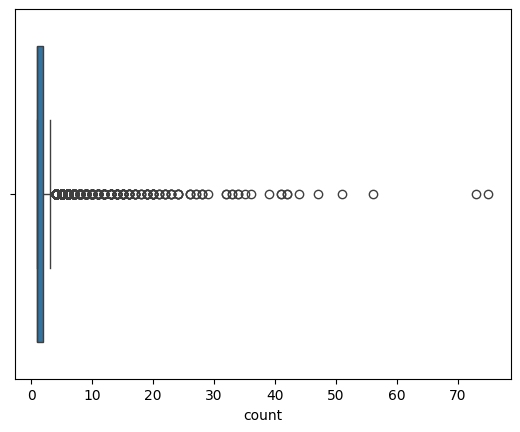

In [ ]:
merged_data.dropna(inplace=True)

# 检查光强分布
sns.boxplot(data=light_data, x='nsb')
plt.show()

# 检查物种数量分布
sns.boxplot(data=species_data, x='count')
plt.show()

In [ ]:
from scipy.stats import boxcox
# 处理目标变量的偏斜分布
merged_data['count_boxcox'], _ = boxcox(merged_data['count'] + 1)
target = 'count_boxcox'


# 归一化
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

scaled_features = scaler_features.fit_transform(merged_data[['nsb']])
scaled_target = scaler_target.fit_transform(merged_data[[target]])

# 创建时间序列
def create_sequences(features, target, time_steps=30):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y).reshape(-1, 1)

time_steps = 30
X, y = create_sequences(scaled_features, scaled_target, time_steps)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Concatenate, Input, Bidirectional
# 模型

def build_model_with_attention(input_shape):
    inputs = Input(shape=input_shape)

    # 双向LSTM层
    lstm1 = Bidirectional(LSTM(200, activation='relu', return_sequences=True))(inputs)
    dropout1 = Dropout(0.2)(lstm1)

    lstm2 = Bidirectional(LSTM(200, activation='relu', return_sequences=True))(dropout1)
    dropout2 = Dropout(0.2)(lstm2)

    # 注意力机制
    attention = Attention()([dropout2, dropout2])
    concat = Concatenate()([dropout2, attention])

    # 全连接层
    dense = Dense(50, activation='relu')(concat)
    output = Dense(1)(dense)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=Huber())
    return model



In [ ]:
# K折交叉验证

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 构建模型
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model_with_attention(input_shape)

    # 训练模型
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=0
    )

    # 预测与评估
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler_target.inverse_transform(y_pred[:, -1, :])  # 取最后一个时间步
    y_test_rescaled = scaler_target.inverse_transform(y_test)

    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mse_scores.append(mse)

print(f"Cross-validated MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Cross-validated MSE: 0.0021 ± 0.0000


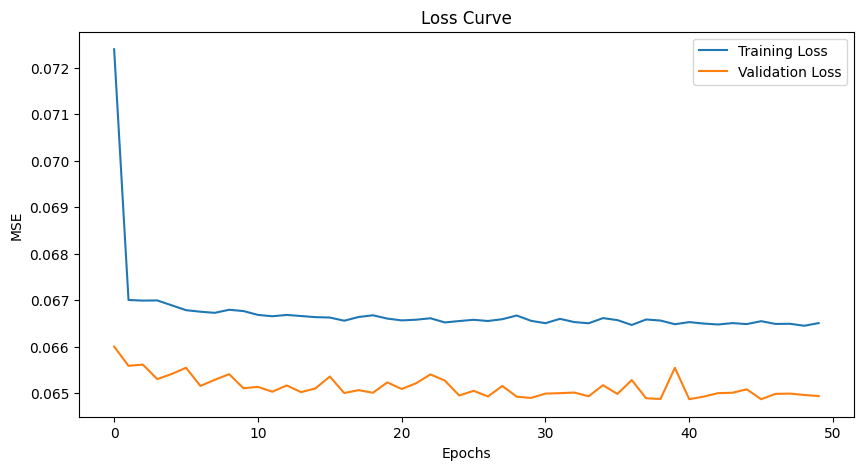

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


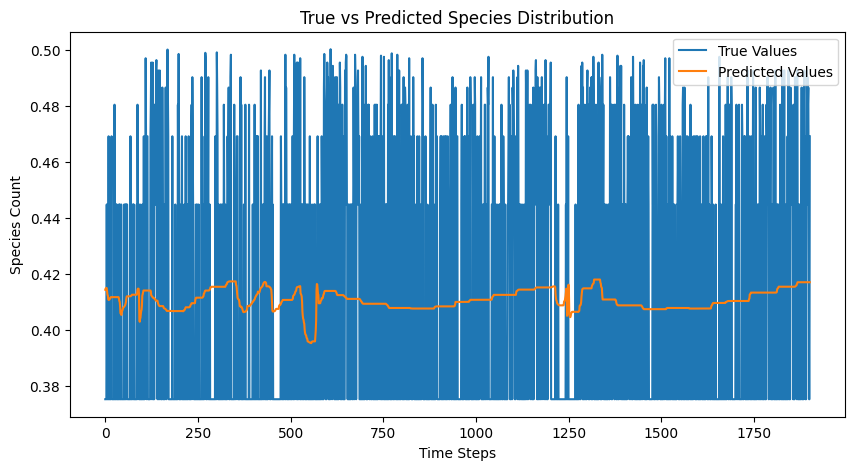

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()



y_pred_rescaled = scaler_target.inverse_transform(model.predict(X_test)[:, -1, :])  # 取最后一个时间步
y_test_rescaled = scaler_target.inverse_transform(y_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='True Values')
plt.plot(y_pred_rescaled, label='Predicted Values')
plt.title('True vs Predicted Species Distribution')
plt.xlabel('Time Steps')
plt.ylabel('Species Count')
plt.legend()
plt.show()

In [ ]:
print("训练集目标变量分布：")
print(y_train.min(), y_train.max())
print("\n验证集目标变量分布：")
print(y_test.min(), y_test.max())

训练集目标变量分布：
0.0 0.9999999999999996

验证集目标变量分布：
0.0 0.9995694734121119
